In [2]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import os
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import yfinance as yf




In [178]:
#ENTER YOUR USERNAME 

user = 'omarlodhi'

# Define the folder containing the CSV files
folder_path = f'/Users/{user}/Downloads/UVAmacro-main/post_2/data/investing.com'



# Define the function that preprocesses the DataFrame
def investingdotcom_preprocess(df, df_name):
    # Convert 'Date' column to the desired format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Remove 'df_' from the DataFrame name and use it as the new column name for 'Price'
    new_column_name = df_name[3:]  # Remove the 'df_' prefix
    
    # Rename 'Price' column to the new name based on DataFrame name
    df.rename(columns={'Price': new_column_name}, inplace=True)
    
    # Reorder the columns to only have the new column and 'Date'
    df = df[[new_column_name, 'Date']]

    return df

# Loop through each CSV file, read it, and preprocess the DataFrame
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]


# Create a list of DataFrames to merge
dfs = []

dfs_dict = {}

# Loop through each CSV file
for csv_file in csv_files:
    df_name = os.path.splitext(csv_file)[0]  # Extract the base name (without extension)
    #print(f"Processing {df_name}...")
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(os.path.join(folder_path, csv_file))
    #print(f"Shape of {df_name}:", df.shape)
    
    # Process the DataFrame (assuming this function processes the DataFrame as needed)
    processed_df = investingdotcom_preprocess(df, f'df_{df_name}')
    
    processed_df['Date'] = pd.to_datetime(processed_df['Date'])

    # Store the processed DataFrame in the dictionary with a dynamic key
    dfs_dict[f'df_{df_name}'] = processed_df

    dfs.append(processed_df)


df_10yr_yield = dfs_dict['df_10yr_yield']
df_1yr_swap_rate = dfs_dict['df_1yr_swap_rate']
df_3yr_swap_rate = dfs_dict['df_3yr_swap_rate']
df_6yr_swap_rate = dfs_dict['df_6yr_swap_rate']

# Load and preprocess the term premium (FRBNY ACM) and breakeven data (FRED)

df_size = pd.read_csv(f'/Users/{user}/Downloads/UVAmacro-main/post_2/data/size.csv')

#print(df_tp.head())

# Extract relevant columns (10Y term premium and date)
df_size['Date'] = pd.to_datetime(df_size['Date'])

# Load and preprocess the BE (Breakeven) data
df_BE = pd.read_csv(f'/Users/{user}/Downloads/UVAmacro-main/post_2/data/5y5y.csv')

df_BE.rename(columns={'observation_date': 'Date', 'T5YIFR': 'BE'}, inplace=True)

df_BE['Date'] = pd.to_datetime(df_BE['Date'])

dfs.append(df_BE)


df_tp = pd.read_csv(f'/Users/{user}/Downloads/UVAmacro-main/post_2/data/ACM.csv')

df_tp = df_tp[['ACMY10', 'DATE']]
df_tp.rename(columns={'ACMY10': '10y_tp', 'DATE': 'Date'}, inplace=True)
df_tp['Date'] = pd.to_datetime(df_tp['Date'])
dfs.append(df_tp)



df_total = dfs[0]




# Merge each subsequent DataFrame on 'Date'

for df in dfs[1:]:
    # Sort each DataFrame by the 'Date' column from earliest to latest

    # Merge with the previous DataFrame (df_total)
    df_total = pd.merge(df_total, df, on='Date', how='inner')

    print(df_total.shape)

    # Print the shape after each merge
    #print(df_total.shape)



df_size['Prop'] = (df_size['Holdings'] / 1000000) / 28

# Step 1: Sort df_size by Date to ensure chronological order
df_size = df_size.sort_values(by='Date')

# Step 2: Function to find the closest date from df_size for each row in df_total
def find_closest_prop(date, df_size):
    # Find the closest date in df_size
    closest_date_idx = (df_size['Date'] - date).abs().idxmin()  # Find index of the closest date
    closest_prop = df_size.loc[closest_date_idx, 'Prop']  # Get the Prop value for the closest date
    return closest_prop

# Step 3: Apply the function to each row in df_total to assign the corresponding Prop
df_total['Prop'] = df_total['Date'].apply(lambda x: find_closest_prop(x, df_size))






# creating necessary variables

df_total['3y3y'] = ((1 + df_total['6yr_swap_rate'])**6 / (1 + df_total['3yr_swap_rate'])**3) - 1


df_total['1y1y'] = ((1 + df_total['2yr_swap_rate'])**2 / (1 + df_total['1yr_swap_rate'])) - 1

df_total = df_total.dropna()


df_total = df_total[df_total['Date']>='2020-01-01']



(1910, 3)
(1688, 4)
(1687, 5)
(1687, 6)
(1686, 7)
(1626, 8)
2025-01-13 00:00:00


/var/folders/zy/p9cjssgn4rdfy2wsbdjm_6w40000gn/T/ipykernel_70441/173301925.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['Date'] = pd.to_datetime(processed_df['Date'])
/var/folders/zy/p9cjssgn4rdfy2wsbdjm_6w40000gn/T/ipykernel_70441/173301925.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['Date'] = pd.to_datetime(processed_df['Date'])
/var/folders/zy/p9cjssgn4rdfy2wsbdjm_6w40000gn/T/ipykernel_70441/173301925.py:47: SettingWithCopyWarning: 
A value is trying to be set o

                            OLS Regression Results                            
Dep. Variable:             10yr_yield   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                 1.209e+04
Date:                Fri, 17 Jan 2025   Prob (F-statistic):               0.00
Time:                        00:51:42   Log-Likelihood:                -69.538
No. Observations:                1259   AIC:                             147.1
Df Residuals:                    1255   BIC:                             167.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2346      0.068     -3.436      0.0

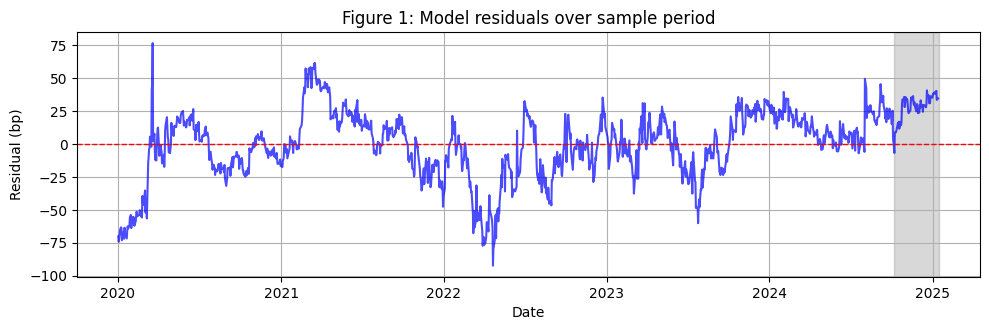

2025-01-13 00:00:00


In [179]:
# main regression

X = df_total[['1y1y', 'BE', 'Prop']]  # Independent variables
y = df_total['10yr_yield']  # Dependent variable

# Step 2: Add a constant to the independent variables matrix (for the intercept in the regression)
X = sm.add_constant(X)

# Step 3: Perform the OLS regression
model = sm.OLS(y, X)  # Ordinary Least Squares regression
results = model.fit()

# Step 4: Display the regression summary
print(results.summary())


# Step 5: Calculate the residuals
y_pred = results.predict(X)  # Predicted values
residuals = y - y_pred  # Residuals
residuals = residuals * 100
df_total['residuals'] = residuals


# Step 7: Plot the residuals
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(df_total['Date'], residuals, color='blue', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Residual (bp)')
plt.title('Figure 1: Model residuals over sample period')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add a red dashed line at 0
plt.axvspan('2024-10-06', '2025-01-15', color='grey', alpha=0.3)
plt.grid(True)
plt.tight_layout()
plt.show()



 

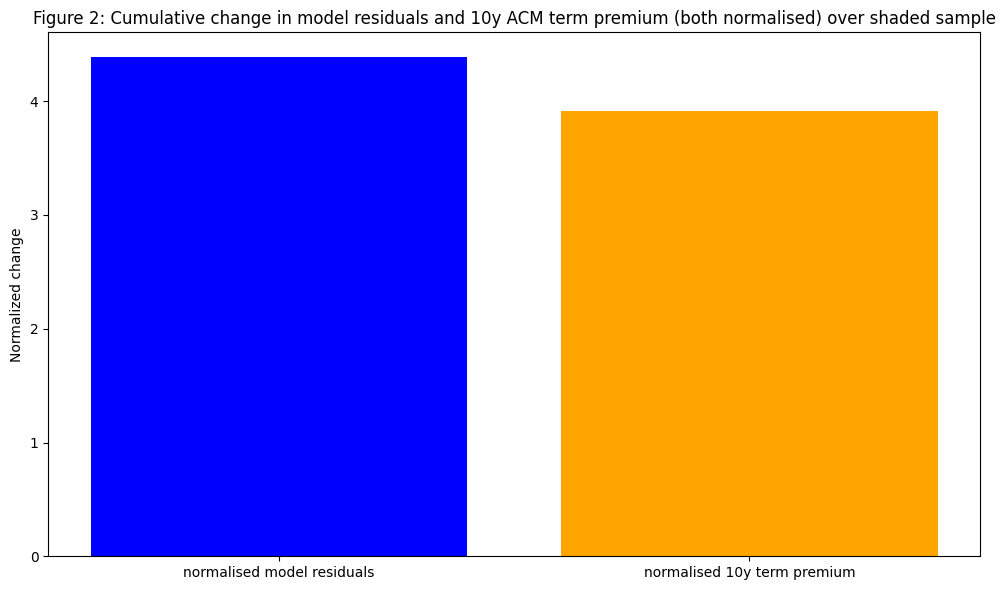

In [272]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

# Assuming df_total, model, and other variables are already defined

# Step 1: Convert 'Date' to datetime if it's not already in datetime format
df_total['Date'] = pd.to_datetime(df_total['Date'])

# Step 2: Define the date range for the shading
start_date = pd.to_datetime('2024-10-06')
end_date = pd.to_datetime('2025-01-15')

# Step 3: Filter data within the date range
df_filtered = df_total[(df_total['Date'] >= start_date) & (df_total['Date'] <= end_date)]

# Sort values by Date
df_filtered = df_filtered.sort_values(by='Date', ascending=True)

# Step 4: Perform the OLS regression
X = df_total[['1y1y', 'BE', 'Prop']]  # Independent variables
y = df_total['10yr_yield']  # Dependent variable
X = sm.add_constant(X)
model = sm.OLS(y, X)  # Ordinary Least Squares regression
results = model.fit()

# Step 5: Calculate the residuals
y_pred = results.predict(X)  # Predicted values
residuals = y - y_pred  # Residuals
residuals = residuals * 100
df_total['residuals'] = residuals

# Step 6: Normalize the residuals and 10y_tp using Z-score (mean = 0, std = 1)
df_filtered['residuals_normalized'] = (df_filtered['residuals'] - df_filtered['residuals'].mean()) / df_filtered['residuals'].std()
df_filtered['10y_tp_normalized'] = (df_filtered['10y_tp'] - df_filtered['10y_tp'].mean()) / df_filtered['10y_tp'].std()

# Step 7: Calculate the total change in normalized residuals and 10y_tp over the shaded period
start_residuals_normalized = df_filtered['residuals_normalized'].iloc[0]
end_residuals_normalized = df_filtered['residuals_normalized'].iloc[-1]
total_change_residuals = end_residuals_normalized - start_residuals_normalized

start_10y_tp_normalized = df_filtered['10y_tp_normalized'].iloc[0]
end_10y_tp_normalized = df_filtered['10y_tp_normalized'].iloc[-1]
total_change_10y_tp = end_10y_tp_normalized - start_10y_tp_normalized

# Step 8: Create a bar graph showing the total changes
fig, ax = plt.subplots(figsize=(10, 6))

# Bar graph for total change in normalized residuals and 10y_tp
labels = ['normalised model residuals', 'normalised 10y term premium']
changes = [total_change_residuals, total_change_10y_tp]

# Plot bars
ax.bar(labels, changes, color=['blue', 'orange'])

# Add titles and labels
ax.set_title('Figure 2: Cumulative change in model residuals and 10y ACM term premium (both normalised) over shaded sample')
ax.set_ylabel('Normalized change')

# Remove gridlines
ax.grid(False)

# Show the plot
plt.tight_layout()
plt.show()




In [268]:
import pandas as pd
import numpy as np

df_filtered = df_filtered.sort_values(by='Date', ascending=True)

total = []

for x in range(100, 110):
    # Assuming df_total has 'Date' and '10y_tp' columns
    # Ensure 'Date' is in datetime format
    df_total['Date'] = pd.to_datetime(df_total['Date'])

    # Step 1: Calculate the 101-day (about 1 month) change in 10y_tp (looking back)
    df_total['monthly_change_10y_tp'] = df_total['10y_tp'] - df_total['10y_tp'].shift(-x)

    # Step 2: Calculate the rolling standard deviation of 101-day changes in 10y_tp
    df_total['monthly_change_std'] = df_total['monthly_change_10y_tp'].rolling(window=x).std()

    df_total['rolling_BE'] = df_total['BE'].rolling(window=x).mean()

    df_total['rolling_BE_back'] = df_total['BE'].shift(-x).rolling(window=x).mean()

    df_total['rolling_BE_back_sd'] = df_total['BE'].shift(-x).rolling(window=x).std()

    # Step 3: Calculate the normalized monthly change by dividing the recent change by the standard deviation of monthly changes
    df_total['normalized_change_10y_tp'] = df_total['monthly_change_10y_tp'] / df_total['monthly_change_std']

    # Now df_total['normalized_change_10y_tp'] represents the number of standard deviations the recent monthly change is

    # Step 4: Calculate the 1-month (101 trading days) change in 10yr_yield (looking forward)
    df_total['change_1month_10yr_yield'] = df_total['10yr_yield'].shift(20) - df_total['10yr_yield']

    # Step 5: Define thresholds for normalized_change_10y_tp (1sd, 2sd, 3sd, etc.)
    thresholds = [1]

    # Step 6: Create a dictionary to store the average changes in 10yr_yield for each threshold
    average_changes = {}

    for threshold in thresholds:
        # Filter the dataset where normalized_change_10y_tp > threshold
        condition = (df_total['normalized_change_10y_tp'] > threshold) & (df_total['rolling_BE'] < df_total['rolling_BE_back'] - df_total['rolling_BE_back_sd'])
        
        # Calculate the average change in 10yr_yield for these cases
        avg_change = df_total.loc[condition, 'change_1month_10yr_yield'].mean()
        
        # Store the result in the dictionary
        average_changes[f'Normalized Change > {threshold} SD'] = avg_change

    total.append(list(average_changes.values())[0])


-0.41931428571428575
-0.4213714285714286
-0.4300833333333334
-0.43268571428571434
-0.44185294117647056
-0.4404571428571429
-0.44424242424242427
-0.45324999999999993
-0.45324999999999993
-0.4414242424242424
